In [1]:
import numpy as np
from numpy import sin,cos,pi
from scipy.linalg import *
from scipy.optimize import fsolve,root
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Homework #8 - _work in progress_

![](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0323.png)

Create the equations of motion and solve the differential algebraic equations (DAE) for a two-bar system under the force of gravity. The system consists of two bars, $l^2=l^3$=1 m each $m^1=m^2$=1 kg. You can modify the solution for the one-bar system given in **A**.

a. Use $\theta^2$ and $\theta^3$ as your independent coordinates

b. Plot $\theta^2$-vs-t and $\theta^3$-vs-t if the system is released from rest at $\theta^2=\theta^3=0$

c. Plot $\theta^2$-vs-t and $\theta^3$-vs-t if the system is released from rest at $\theta^2=0$ and $\theta^3=\pi/18$

d. Create an animation of (c)

## A. Solution of link pinned to ground at origin

In [10]:
l1 = 1

In [11]:
def rotA(theta):
    '''This function returns a 2x2 rotation matrix to convert the 
    rotated coordinate to the global coordinate system
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    A : 2x2 array to rotate a coordinate system at angle theta to global x-y
    '''
    A=np.zeros((2,2))
    A=np.array([[np.cos(theta), -np.sin(theta)],
               [np.sin(theta), np.cos(theta)]])
    
    return A

In [12]:
def A_theta(theta):
    '''This function returns a 2x2 rotation matrix derivative 
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    dAda : 2x2 array derivative of `rotA`
    '''
    dAda=np.array([[-np.sin(theta), -np.cos(theta)],
                   [np.cos(theta), -np.sin(theta)]])
    return dAda

In [19]:
def C_link(q,t):
    '''2 constraint equations for 3 generalized coords
       q=[R1x,R1y,a1]
       q=[R1,     a1]
         [0,1     2 ]
         
              1/
              /     pinned link
             O    
       -----^^^-------------
            
    Parameters
    ----------
    q : numpy array for 9 generalized coordinates for bodies 1-3 in the slider crank
        q = [q1]
    t : current time
    
    Returns
    -------
    C : 2 constraint equation evaluations
    '''
    q1 = q[0:3]
    C=np.zeros(2)
    C[0:2] = q1[0:2]+rotA(q1[2])@np.array([-l1/2, 0])
    return C

In [20]:
def Cq_pin(qi, qj, ui, uj):
    '''Jacobian of a pinned constraint for planar motion

    Parameters
    ----------
    qi : generalized coordinates of the first body, i [Rxi, Ryi, thetai]
    qj : generalized coordinates of the 2nd body, i [Rxj, Ryj, thetaj]
    ui : position of the pin the body-i coordinate system
    uj : position of the pin the body-j coordinate system
        
    Returns
    -------
    Cq_pin : 2 rows x 6 columns Jacobian of pin constraint Cpin
    '''
    
    Cq_1=np.block([np.eye(2), A_theta(qi[2])@ui[:,np.newaxis] ])
    Cq_2=np.block([-np.eye(2), -A_theta(qj[2])@uj[:,np.newaxis] ])
    Cq_pin=np.block([Cq_1, Cq_2])
    return Cq_pin

In [21]:
def Cq_link(q,t):
    '''return Jacobian of C_slidercrank(q,t) = dC/dq_i
       |dC1/dR1x dC1/dR1y dC1/da3 |
       |dC2/dR1x dC2/dR1y dC2/da3 |
    
    Parameters
    ----------
    q : numpy array for 3 generalized coordinates for body 1 in the rotating link
        q = [q1]
    t : current time
    Returns
    -------
    Cq : 2 rows x 3 columns Jacobian of constraints `C_link`   
    '''
    q1 = q[0:3]
    
    Cq=np.zeros((2,3))
    Cq[0:2, 0:3] = Cq_pin(q1, np.array([0, 0, 0]),np.array([-l1/2, 0]),np.array([0, 0]))[0:2, 0:3]
    return Cq

Define some definitions for $A$, $A_\theta$ and g

In [22]:
def g(system='ms'):
    '''define gravity for m-s, ft-s,mm-s'''
    if system=='ms':
        return 9.81
    elif system=='fts':
        return 32.2
    elif system=='mms':
        return 9.81e3
    else:
        print('warning: system not defined yet, giving you 9.81 m/s/s')
        return 9.81
  

Define constraint formed by a pin constraint

Define Jacobian of pin constraint

The bar uses the first three columns of the pin-constraint Jacobian 

(unless you add q1 for the ground link)

$\mathbf{B_i}=[-\mathbf{C_{q_d}^{-1}C_{q_i}},~\bar{I}]^T$

In [35]:
def Bi_link(q, t):
    '''B.T*M*B-B.T*Qe = 0 '''
    Cq = Cq_link(q, t)
    Cqd=Cq[0:2,0:2]
    Cqi=Cq[0:2,2].reshape(2,1)
    #print(-np.linalg.inv(Cqd)@Cqi)
    Bi=np.vstack((-np.linalg.inv(Cqd)@Cqi,np.eye(1)))
    return Bi

In [36]:
Bi_link(np.array([0,0.5,np.pi/2]), 0)

array([[-5.000000e-01],
       [ 3.061617e-17],
       [ 1.000000e+00]])

The equation of motion for the general embedding method is as such

$$\mathbf{B^TMB +B^TM\gamma-B^TQ_e = 0}$$

$$\gamma = \left[\begin{array}
\mathbf{-C_{qd}^{-1}[(C_q\dot{q})_q\dot{q}+2C_{qt}\dot{q}+C_{tt}}] \\
\mathbf{0}\end{array}\right] = \left[\begin{array}
\mathbf{C_{qd}^{-1}[Q_d]} \\
\mathbf{0}\end{array}\right]$$

where $\mathbf{B}=\mathbf{B(q)}$ and $\mathbf{\gamma = \gamma}(\mathbf{q,~\dot{q},}~t)$. This presents a system of __differential algebraic equations__. You need to solve for $\mathbf{q}$ and $\dot{\mathbf{q}}$ at each step. The one-bar and two-bar linkage contraints do not time-dependent terms so  $\mathbf{\gamma}=\mathbf{0}$.

Solution process:

1. define a `global` variable `q0` that updates the initial guess for $\mathbf{C}(\mathbf{q},~t)=\mathbf{0}$
2. Use _state_ $y=[\theta^1,~\dot{\theta}^1]$ to add constraints to $\mathbf{C}(\mathbf{q},~t)$
3. 


Define equation of motion to return $\dot{y}=[\dot{\theta}^1,~\ddot{\theta}^1]^T$ and $\mathbf{q}= [R_x^1,~R_y^1,~\theta^1]^T$, where $y=[\theta^1,~\dot{\theta}^1]^T$ and $\mathbf{q} $. 


In [171]:
l1=1
q0=np.array([l1/2, 0, 0])
def eom_bar(ti, y, li = l1, mi = 0.1, ):
    '''    
    Parameters
    ----------
    ti : current time
    y : numpy array for independent generalized coordinates for body 1 in the rotating link
        y = [theta, dtheta/dt]
    
    Returns
    -------
    dy : derivative for the independent generalized coordinate for body 1
         dy = [dtheta/dt, ddtheta/ddt]
    '''
    global q0
    
    q0[2]=y[0]
    
    q = fsolve(lambda q: np.block([C_link(q, t),q[2]-y[0]]),q0, \
                  fprime= lambda q: np.vstack((Cq_link(q,t),np.array([0,0,1]))))
    
    Bi = Bi_link(q, t)
    M = np.diag([mi,mi,mi*li**2/12])
    Qe = np.array([0, -mi*g(), 0])
    dy = np.zeros(y.shape)
    dy[0] = y[1]
    dy[1] = solve(Bi.T@M@Bi,Bi.T@Qe)
    return dy, q

In [173]:
eom_bar(0.1, np.array([-pi/2+0, 0]))[0]

array([ 0.00000000e+00, -9.01033882e-16])

In [162]:
t[1]/2

0.030612244897959183

The `solve_ivp` only solves odes of the form `dy=f(t,y)` so we create an ode function that fits this form.

Then, we can integrate and post-process.

In [200]:
li = 1
mi = 0.1
t = np.linspace(0,4)
q = np.zeros((3, len(t)))
sol=solve_ivp(lambda t, y: eom_bar(t,y)[0], t_span=[0,t.max()], y0=[0,0], t_eval=t)

Text(0.5, 1.0, 'independent general coord theta')

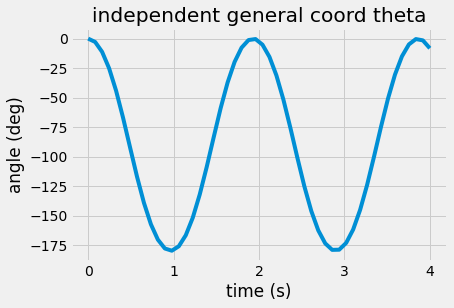

In [201]:
plt.plot(sol.t,sol.y[0]*180/np.pi)

plt.xlabel('time (s)')
plt.ylabel('angle (deg)')
plt.title('independent general coord theta')

We can plug in our solution `sol.y` for $\mathbf{q}$ as a function of time to get the other generalized coordinates.



In [202]:
q=np.zeros((3,len(t)))
for i,tt in enumerate(t):
    dy, qi = eom_bar(t,sol.y[:,i])
    q[:,i] = qi

Text(0.5, 1.0, 'path of link COM')

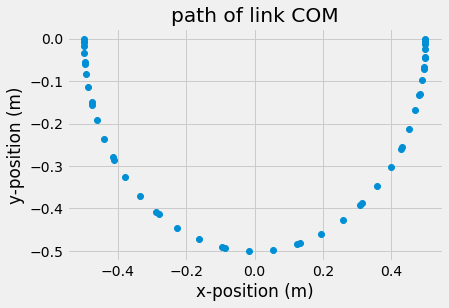

In [203]:
plt.plot(q[0,:],q[1,:], 'o')
plt.xlabel('x-position (m)')
plt.ylabel('y-position (m)')
plt.title('path of link COM')

and even animate our results 

## Animate the motion

Next, you animate the motion of the system. Below, you create 

1. `plot_shape` to create lines and markers to represent links and the sliding base
2. a figure that shows the path of the two link centers of mass
3.`init` to initialize the animation
4. `animate` to update the two links and sliding base
5. `FuncAnimation` to display the motion of the slidercrank system

In [204]:
def plot_shape(shape,dims,q):
    '''
    function to plot a shape based upon the shape dimensions and coordinates
    arguments:
    ----------
    shape: either 'link' or 'base',
            - the link returns two points to plot as a line
            - the base returns one point to plot as a marker
            - if neither 'link' or 'base' are chosen, then 0 is returned and warning printed 
            `choose a \'link\' or \'base\' please`
    dims: the dimensions of the shape
            - the link uses the first value as the length
            - the base ignores the `dims`
    q: generalized coordinates in the form [Rx, Ry, theta]
            - the link returns the center of the link at (Rx, Ry) and oriented at theta
            - the base returns the center at (Rx, Ry) and ignores theta
    returns:
    --------
    datax: coordinates to plot the x-positions
    datay: coordinates to plot the y-positions
            - the link returns array of length 2
            - the base returns array of length 1
    
    '''

    if shape=='link':
        left = rotA(q[2])@np.array([-dims[0]/2, 0])
        right = rotA(q[2])@np.array([dims[0]/2, 0])
        Px=q[0]+np.array([left[0], right[0]])
        Py=q[1]+np.array([left[1], right[1]])
        datax = Px
        datay = Py
        #l,= plt.plot(Px,Py,'o-')
        return datax, datay
    elif shape=='base':
        Px=q[0]
        Py=q[1]
        data = [Px, Py]
        #l,=plt.plot(Px,Py,'s',markersize=20)
        return data
    else:
        print('choose a \'link\' or \'base\' please')
        return 0


### 2. initialize the lines and coordinate system

Text(0.5, 1.0, 'link motion and paths')

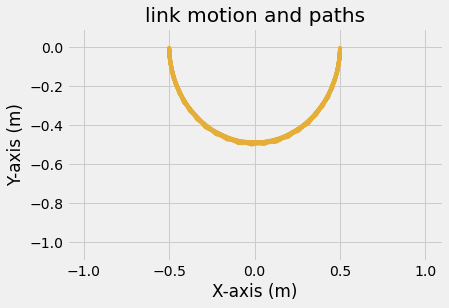

In [205]:
q1 = q[0:3, :]

fig, ax = plt.subplots()
link1, = ax.plot([], [], linewidth = 10)
body3, = ax.plot([], [], 's', markersize = 20)
path1, = ax.plot(q1[0, :], q1[1, :])
ax.set_xlim((-1.1,1.1))
ax.set_ylim((-1.1, 0.1))
ax.set_xlabel('X-axis (m)')
ax.set_ylabel('Y-axis (m)')
ax.set_title('link motion and paths')

### 3. and 4. create your `init` and `animation` functions to update the lines on the plot
Create an initializing (`init`) function that clears the previous lines and markers

Create an animating (`animate`) function that updates the link, base, and path

In [206]:
def init():
    link1.set_data([], [])
    return (link1, )

In [207]:
def animate(i):
    '''function that updates the line and marker data
    arguments:
    ----------
    i: index of timestep
    outputs:
    --------
    link1: the line object plotted in the above ax.plot(...)
    '''

    datax, datay = plot_shape('link', np.array([l1]), q1[:, i])
    link1.set_data(datax, datay)
    
    return (link1, )

#### 4. display the result in an HTML video

Import the `animation` and `HTML` functions. Then, create an animation (`anim`) variable using the `animation.FuncAnimation`

In [208]:
from matplotlib import animation
from IPython.display import HTML

In [209]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=range(0,len(t)), interval=50, 
                               blit=True)

In [210]:
HTML(anim.to_html5_video())